In [1]:
import pandas as pd
from metpy.units import units
from metpy.calc import (wind_components, wind_speed, wind_direction, relative_humidity_from_mixing_ratio, 
                        mixing_ratio_from_specific_humidity)
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib as mpl
import numpy as np
import xarray as xr
import pytz
from wrf import latlon_coords

np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                 


In [2]:
def plot_station_barbs(data, date_time, var_key, stations, y_pos, data_units, cmap_levels, 
                       skip, data_key, figsize, lab, outdir):    
    
    cmap_spec = mpl.cm.jet
    norm = mpl.colors.Normalize(vmin=cmap_levels[0], vmax=cmap_levels[1])
    
    # Create a new figure
    fig, ax = plt.subplots(1,1, figsize=figsize)
    
    for i in range(len(stations)):

        # plot barbs for each station on a different line
        br = ax.barbs(date_time[::skip], (np.ones(len(date_time)) * y_pos[i])[::skip], \
                 data.u.sel(station = stations[i])[::skip], data.v.sel(station = stations[i])[::skip], \
                 data[var_key].sel(station = stations[i])[::skip], cmap=cmap_spec, norm = norm, \
                      sizes=dict(emptybarb=0.1, spacing=0.2, height=0.5))

        # find missing values and plot them as x's
        missing = (np.isfinite(data[var_key].sel(station = stations[i]).values) == False).astype(int) * 40
        plt.scatter(date_time[::skip], (np.ones(len(date_time)) * y_pos[i])[::skip], missing[::skip], marker = 'x', color = 'gray')
        
        ax.set_yticks(y_pos)
        ax.set_ylim(np.min(y_pos) - 0.5, np.max(y_pos) + 0.5)
        
        labels = [item.get_text() for item in ax.get_yticklabels()]
        labels = stations
        ax.set_yticklabels(labels)

        # make x laeled dates prettier
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%H'))

    plt.title(lab, fontsize = 15, loc = 'center')

        
    plt.title('(' + str(date_time['time.month'].values[0]) + '/' + str(date_time['time.year'].values[0]) + ')', 
              loc = 'right')
        
    ax2 = fig.add_axes([0.91, 0.15, 0.009, 0.7])

#     cb = mpl.colorbar.ColorbarBase(ax2, cmap=cmap_spec,
#                                 norm=norm, orientation='vertical')
    cb = plt.colorbar(br, cax=ax2,
                        orientation='vertical', extendfrac='auto', label = data_units)


   
    # Save and display figure
    plot_name = data_key + '_' + var_key + '_' + str(skip) + 'hrly_' + str(date_time.values[0])[:-16].replace('T', '_') + \
                '_to_' + str(date_time.values[-1])[:-16].replace('T', '_') + '.png'
    plt.savefig(outdir+plot_name,  bbox_inches='tight', dpi = 120)
    plt.show()
    print('File saved as:', outdir+plot_name, '\n')

In [3]:
wnd_units = 'm/s'

# set filepath
datadir = '../input_data/station_data/'

# set output filepath
outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/'
fig_outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/'
dat_outdir = '/home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/data/'

station_lats = [34.42611, 34.455886, 34.4450, 34.491333, 34.516658,  34.461397,   34.544397,  34.60694]
station_lons = [-119.84361, -119.705628, -119.625833, -119.796386, -120.075331, -119.649014, -119.791286, -120.07556] 
stations = ["KSBA", "SBVC1", "MOIC1", "MPWC1", "RHWC1", "MTIC1", "LPOC1", "KIZA"]

da_list = []


# loop through stations
for j in range(len(stations)):
    
    # read in station data
    station = stations[j]

    filepath = datadir + station + '_marine_layer_case_study' +'.csv'

    df = pd.read_csv(filepath, header=6, skiprows = [7])
    print('Opened File:', filepath)    

    # save data
    T = df['air_temp_set_1'].values
    RH = df['relative_humidity_set_1'].values
    wspd = df['wind_speed_set_1'].values
    wdir = df['wind_direction_set_1'].values
    wgust = df['wind_gust_set_1'].values
    pres = df['sea_level_pressure_set_1d'] / 100 # convert to hpa
    dates = df['Date_Time'].values    
    
    u, v = wind_components(wspd  * units('m/s'), wdir  * units('degree'))

    # save times as datetimes
    date_time = []
        
    for i in range(len(df)):
    
        # converting dates list of string to datetimes and storing the timezone
        # round to nearest hour
        datetime_obj = datetime.strptime(dates[i], '%m/%d/%Y %H:%M %Z')
        datetime_rnd = datetime_obj.replace(second=0, microsecond=0, minute=0, hour=datetime_obj.hour) + \
                        timedelta(hours=datetime_obj.minute//30)
        date_time.append(datetime_rnd)
        
        # if winds speeds are zero, set to nan
        #if (wspd[i] == 0):
        #    wspd[i] = np.nan
        #    wdir[i] = np.nan
    
    # save data into xarray
    dat = xr.Dataset({'t': (['time'], T),
                    'RH': (['time'], RH),
                    'slp': (['time'], pres),
                    'wspd': (['time'], wspd),
                    'wdir': (['time'], wdir),
                    'u': (['time'], u),
                    'v': (['time'], v),
                    'wgust': (['time'], wgust)},
                      coords = {'time': date_time, 'station': station})

    # correct some stations so they all have the same number of points
    if (station == 'SBVC1' or station == 'KIZA' or station == 'KSBA'):
        dat = dat.resample(time = '1H').mean()
    
    # append xarray to a list
    da_list.append(dat)

# convert list of xarrays to one xarray
da = xr.concat(da_list, dim = 'station')

Opened File: ../input_data/station_data/KSBA_marine_layer_case_study.csv


/home/sbarc/students/coello/miniconda3/envs/general/lib/python3.7/site-packages/xarray/core/common.py:1124: FutureWarning: 'base' in .resample() and in Grouper() is deprecated.
The new arguments that you should use are 'offset' or 'origin'.

>>> df.resample(freq="3s", base=2)

becomes:

>>> df.resample(freq="3s", offset="2s")

  freq=freq, closed=closed, label=label, base=base, loffset=loffset
/home/sbarc/students/coello/miniconda3/envs/general/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Opened File: ../input_data/station_data/SBVC1_marine_layer_case_study.csv


/home/sbarc/students/coello/miniconda3/envs/general/lib/python3.7/site-packages/pint/numpy_func.py:728: RuntimeWarning: Mean of empty slice
  ret = func(*bound_args.args, **bound_args.kwargs)


Opened File: ../input_data/station_data/MOIC1_marine_layer_case_study.csv
Opened File: ../input_data/station_data/MPWC1_marine_layer_case_study.csv
Opened File: ../input_data/station_data/RHWC1_marine_layer_case_study.csv
Opened File: ../input_data/station_data/MTIC1_marine_layer_case_study.csv
Opened File: ../input_data/station_data/LPOC1_marine_layer_case_study.csv
Opened File: ../input_data/station_data/KIZA_marine_layer_case_study.csv


## Open Simulation Results

In [4]:
# Set filepath
datadir = '../input_data/wrf_out_post/'

# set file names
filename = ['wrfout_d03_2017-05-22_00:00:00_surf', 'wrfout_d03_2017-05-23_00:00:00_surf', 
            'wrfout_d03_2017-05-24_00:00:00_surf', 'wrfout_d03_2017-05-25_00:00:00_surf']   

da_list = []
dates_list = []


for j in range(len(filename)):

    # open wrf Dataset object
    filepath = datadir + filename[j]
    dat = xr.open_dataset(filepath)
    print('Opened File:', filepath)

    # append xarray to a list
    da_list.append(dat)

# convert list of xarrays to one xarray
ds = xr.concat(da_list, dim = 'time')

# limit wrf data time frame by station datae
ds = ds.sel(time = slice(str(ds.time.values[0]), str(ds.time.values[-1])))

da_list = []

# adjust station lats and lons to have the nearest wrf lat and lon to station location
for i in range(len(stations)):
        
    # interpoalte to specific station location
    ds_tmp = ds.interp(lat = station_lats[i], lon = station_lons[i])
    
    # add station name as coordinate
    ds_tmp = ds_tmp.assign_coords(station = stations[i])
    
    # append xarray to a list
    da_list.append(ds_tmp)
    
# convert list of xarrays to one xarray
dwrf = xr.concat(da_list, dim = 'station')

/home/sbarc/students/coello/miniconda3/envs/general/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'rh2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/home/sbarc/students/coello/miniconda3/envs/general/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'rh2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


Opened File: ../input_data/wrf_out_post/wrfout_d03_2017-05-22_00:00:00_surf
Opened File: ../input_data/wrf_out_post/wrfout_d03_2017-05-23_00:00:00_surf


/home/sbarc/students/coello/miniconda3/envs/general/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'rh2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/home/sbarc/students/coello/miniconda3/envs/general/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'rh2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


Opened File: ../input_data/wrf_out_post/wrfout_d03_2017-05-24_00:00:00_surf
Opened File: ../input_data/wrf_out_post/wrfout_d03_2017-05-25_00:00:00_surf


## Open Climotology Results

In [7]:
# set file names
filename = ['wrfout_d04_2017-05-22_00:00:00_surf_climo', 'wrfout_d04_2017-05-23_00:00:00_surf_climo', 
            'wrfout_d04_2017-05-24_00:00:00_surf_climo', 'wrfout_d04_2017-05-25_00:00:00_surf_climo']   

da_list = []
dates_list = []


for j in range(len(filename)):

    # open wrf Dataset object
    filepath = datadir + filename[j]
    dat = xr.open_dataset(filepath)
    print('Opened File:', filepath)

    # append xarray to a list
    da_list.append(dat)

# convert list of xarrays to one xarray
ds = xr.concat(da_list, dim = 'time')

# limit wrf data time frame by station datae
ds = ds.sel(time = slice(str(ds.time.values[0]), str(ds.time.values[-1])))

da_list = []

# adjust station lats and lons to have the nearest wrf lat and lon to station location
for i in range(len(stations)):
        
    # interpoalte to specific station location
    ds_tmp = ds.interp(lat = station_lats[i], lon = station_lons[i])
    
    # add station name as coordinate
    ds_tmp = ds_tmp.assign_coords(station = stations[i])
    
    # append xarray to a list
    da_list.append(ds_tmp)
    
# convert list of xarrays to one xarray
dclimo = xr.concat(da_list, dim = 'station')

/home/sbarc/students/coello/miniconda3/envs/general/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'rh2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/home/sbarc/students/coello/miniconda3/envs/general/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'rh2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/home/sbarc/students/coello/miniconda3/envs/general/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'rh2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,
/home/sbarc/students/coello/miniconda3/envs/general/lib/python3.7/site-packages/xarray/conventions.py:498: SerializationWarning: variable 'rh2' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  decode_timedelta=decode_timedelta,


Opened File: ../input_data/wrf_out_post/wrfout_d04_2017-05-22_00:00:00_surf_climo
Opened File: ../input_data/wrf_out_post/wrfout_d04_2017-05-23_00:00:00_surf_climo
Opened File: ../input_data/wrf_out_post/wrfout_d04_2017-05-24_00:00:00_surf_climo
Opened File: ../input_data/wrf_out_post/wrfout_d04_2017-05-25_00:00:00_surf_climo


In [12]:
dclimo = dclimo.sel(time = slice(str(dwrf.time.values[0]), str(dwrf.time.values[-1])))

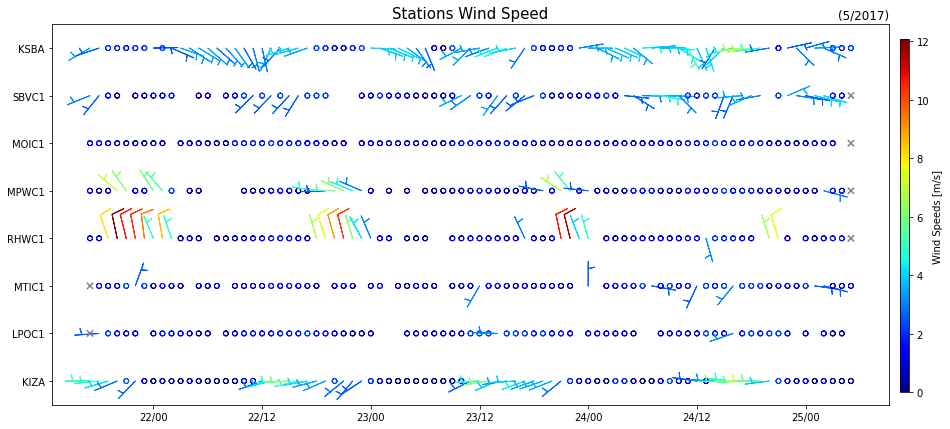

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/stations_wspd_1hrly_2017-05-21_17_to_2017-05-25_05.png 



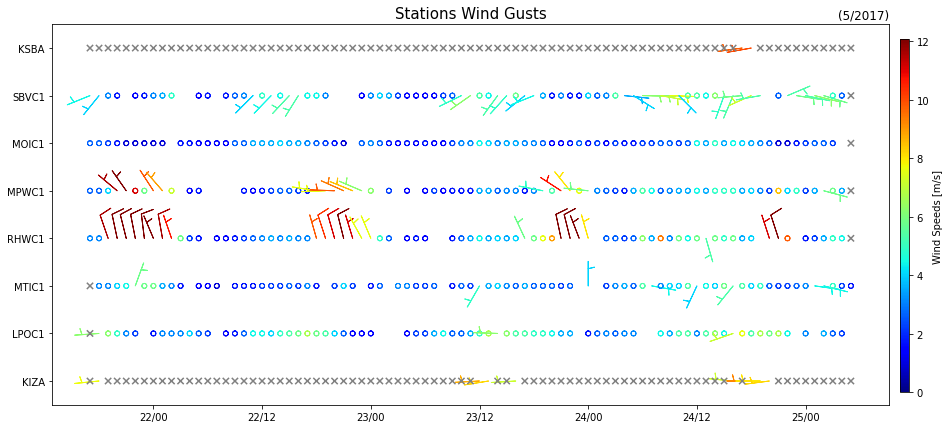

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/stations_wgust_1hrly_2017-05-21_17_to_2017-05-25_05.png 



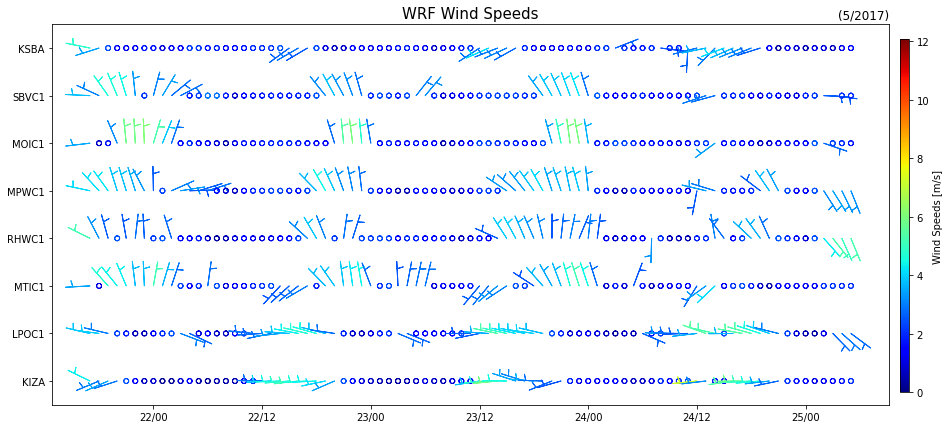

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/wrf_wspd_1hrly_2017-05-21_17_to_2017-05-25_05.png 



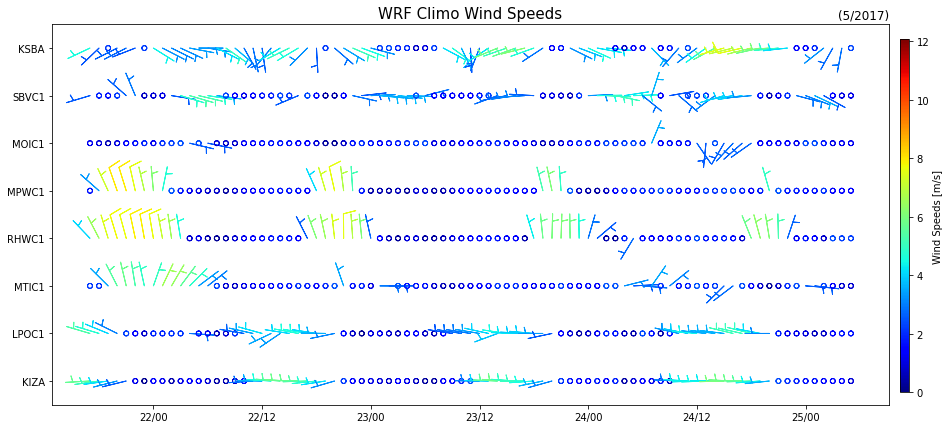

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/wrf_climo_wspd_1hrly_2017-05-21_17_to_2017-05-25_05.png 



In [14]:
levels_wspd = [0, np.nanmax(da.wspd)]

station_order = [8, 7, 6, 5, 4, 3, 2, 1]

plot_station_barbs(da, da.time, 'wspd', stations, station_order, \
                   'Wind Speeds [' + wnd_units + ']', levels_wspd, 1, 'stations', \
                   (15,7), 'Stations Wind Speed', fig_outdir)

plot_station_barbs(da, da.time, 'wgust', stations, station_order, \
                   'Wind Speeds [' + wnd_units + ']', levels_wspd, 1, 'stations', \
                   (15,7), 'Stations Wind Gusts', fig_outdir)

plot_station_barbs(dwrf, da.time, 'wspd', stations, station_order, \
                   'Wind Speeds [' + wnd_units + ']', levels_wspd, 1, 'wrf',\
                   (15,7), 'WRF Wind Speeds', fig_outdir)

plot_station_barbs(dclimo, da.time, 'wspd', stations, station_order, \
                   'Wind Speeds [' + wnd_units + ']', levels_wspd, 1, 'wrf_climo',\
                   (15,7), 'WRF Climo Wind Speeds', fig_outdir)

In [22]:
dwrf = dwrf.rename({'T2' : 't', 'rh2' : 'RH'})    

In [16]:
dclimo = dclimo.rename({'T2' : 't', 'rh2' : 'RH'})    

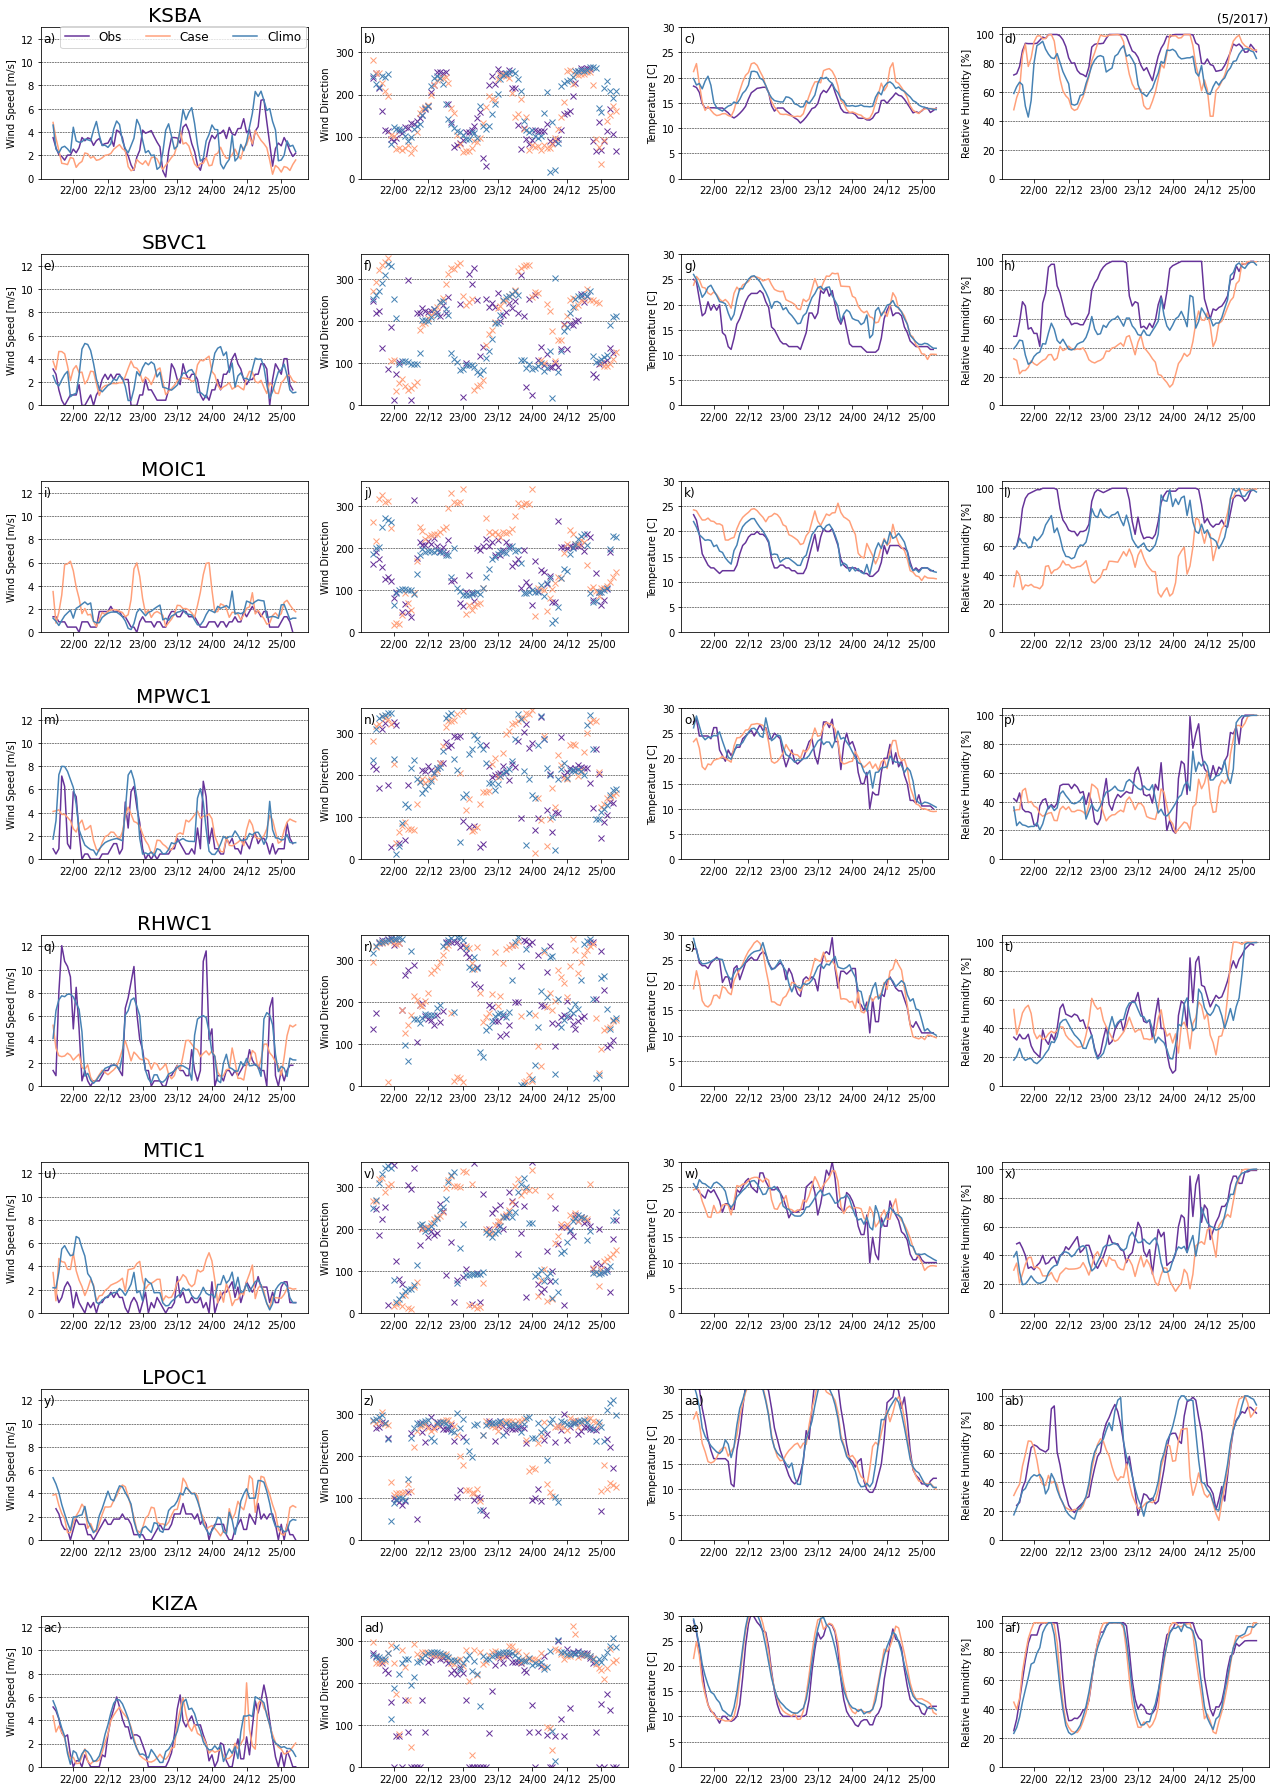

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/KSBA_SBVC1_MOIC1_MPWC1_RHWC1_MTIC1_LPOC1_KIZA_wspd_wdir_t_RH_2017-05-21_17_to_2017-05-25_05.png 



In [28]:
def plot_station_winds(data, data_names, data_cols, date_time, stations, var, var_labs, var_lims, \
                       line_sty, station_lab, leg_box, wind_untis, fig_size, outdir):    
    
    var_names = ''
    stat_names = ''
    subfig = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)', 'm)', 'n)', 'o)',
             'p)', 'q)', 'r)', 's)', 't)', 'u)', 'v)', 'w)', 'x)', 'y)', 'z)', 'aa)', 'ab)', 'ac)', 'ad)', 'ae)', 'af)']
    
    k = 0
    
    lns = []
    
    # Create a new figure
    fig = plt.figure(figsize=fig_size)       
    gs = plt.GridSpec(len(stations), len(var), figure=fig, hspace= 0.5, wspace=0.2)
    
    for i in range(len(stations)):
    
        for j in range(len(var)):
    
            ax = fig.add_subplot(gs[i,j])

            for m in range(len(data)):
        
                ln1 = ax.plot(data[m].time, data[m][var[j]].sel(station = stations[i]), data_cols[m], \
                          label=data_names[m], linestyle = line_sty[j][0], marker = line_sty[j][1])
            
                if (i == 0 and j == 0):
                    lns += ln1

            ax.set_ylabel(var_labs[j], multialignment='center')
            ax.set_ylim(var_lims[j])

#             ln2 = ax.plot(wrf.time, wrf[wrf_var[j]].sel(station = stations[i]), 'lightsalmon', label='Modeled', \
#                          linestyle = line_sty[j][0], marker = line_sty[j][1])

            # make x laeled dates prettier
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%d/%H'))

            if (i == 0 and j == len(var) - 1):
                plt.title('(' + str(date_time['time.month'].values[0]) + '/' + \
                          str(date_time['time.year'].values[0]) + ')', loc = 'right')

            # apply grid
            ax.grid(b=True, which='major', axis='y', color='k', linestyle='--', linewidth=0.5)

            ax.text(0.01, 0.9, subfig[k], fontsize = 12, transform = ax.transAxes)

            
            if (j == station_lab):
                plt.title(stations[i], loc = 'center', size = 20)

        
            if (i == 0 and j == 0):
                # add legend
#                 lns = ln1 + ln2
                labs = [l.get_label() for l in lns]
                ax.legend(lns, labs, loc='upper left',  bbox_to_anchor=leg_box, ncol=3, prop={'size': 12})
                
            if (i == 1):
                var_names = var_names + '_' + str(var[j])
                
                
            k += 1
            
        stat_names = stat_names + '_' + stations[i]
   
    # Save and display figure
    plot_name = stat_names[1:] + var_names + '_' + str(date_time.values[0])[:-16].replace('T', '_') + \
                '_to_' + str(date_time.values[-1])[:-16].replace('T', '_') + '.png'
    plt.savefig(outdir+plot_name,  bbox_inches='tight', dpi = 120)
    plt.show()
    print('File saved as:', outdir+plot_name, '\n')

    
station_vars = ['wspd', 'wdir', 't', 'RH']
var_labels = ['Wind Speed [' + wnd_units + ']', 'Wind Direction', 'Temperature [C]', 'Relative Humidity [%]']
var_lims = [(0,13), (0, 360), (0,30), (0,105)]
line_labs = [('-', None), ('','x'), ('-', None), ('-', None)]
    
    
plot_station_winds([da, dwrf, dclimo], ['Obs', 'Case', 'Climo'], \
                   ['rebeccapurple', 'lightsalmon', 'steelblue'], da.time, stations,  station_vars, \
                   var_labels, var_lims, line_labs, 0, \
                   (0.05, 1.05), wnd_units, (22, 32), fig_outdir)

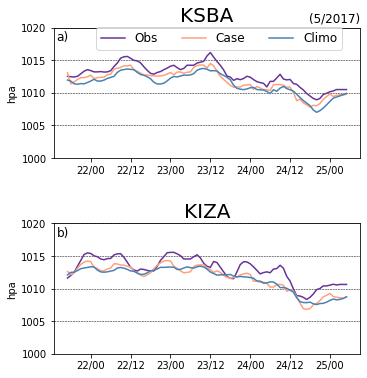

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/KSBA_KIZA_slp_2017-05-21_17_to_2017-05-25_05.png 



In [31]:
station_vars = ['slp']
wrf_vars = ['slp']
var_labels = ['hpa']
var_lims = [(1000, 1020)]
line_labs = [('-', None)]


plot_station_winds([da, dwrf, dclimo], ['Obs', 'Case', 'Climo'], \
                   ['rebeccapurple', 'lightsalmon', 'steelblue'], \
                   da.time, ["KSBA", "KIZA"], \
                   station_vars, var_labels, var_lims, line_labs, \
                   0, (0.12, 1.05), wnd_units, (5.5, 6), fig_outdir)

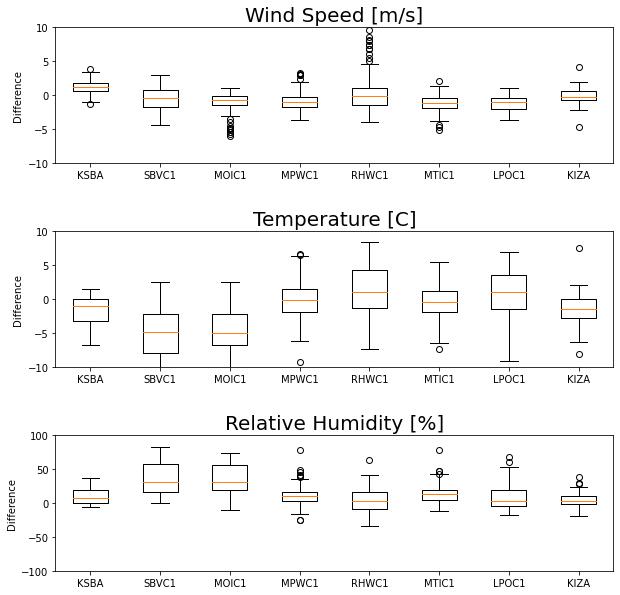

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/error_analysis_case_study_KSBA_SBVC1_MOIC1_MPWC1_RHWC1_MTIC1_LPOC1_KIZA_wspd_t_RH_2017-05-21_17_to_2017-05-25_05.png 



In [33]:
def station_errors(data1, data2, date_time, stations, var, var_labs, var_lims, \
                     fig_size, test_name, outdir):    
    
    var_names = ''
    stat_names = ''
    subfig = ['a)', 'b)', 'c)', 'd)', 'e)', 'f)', 'g)', 'h)', 'i)', 'j)', 'k)', 'l)', 'm)', 'n)', 'o)',
             'p)', 'q)', 'r)', 's)', 't)', 'u)', 'v)', 'w)', 'x)', 'y)', 'z)', 'aa)', 'ab)', 'ac)', 'ad)', 'ae)', 'af)']
        
    # Create a new figure
    fig = plt.figure(figsize=fig_size)       
    gs = plt.GridSpec(len(var), 1, figure=fig, hspace= 0.5, wspace=0.2)
    
    for j in range(len(var)):
    
        ax = fig.add_subplot(gs[j,0])
    
        da_var = []
    
        for i in range(len(stations)):
    
            da = data1[var[j]].sel(station = stations[i]).values - data2[var[j]].sel(station = stations[i]).values
    
            da_filtered = da[~np.isnan(da)]
    
            da_var.append(da_filtered)
        
            if (j == 0):
                stat_names = stat_names + '_' + stations[i]
        
        var_names = var_names + '_' + str(var[j])

        plt.boxplot(da_var)
        
        ax.set_ylabel('Difference', multialignment='center')
        ax.set_ylim(var_lims[j])
        
        ax.set_xticklabels(stations)

        plt.title(var_labs[j], loc = 'center', size = 20)
                         
   
    # Save and display figure
    plot_name = 'error_analysis_' + test_name + '_' + stat_names[1:] + var_names + '_' + str(date_time.values[0])[:-16].replace('T', '_') + \
                '_to_' + str(date_time.values[-1])[:-16].replace('T', '_') + '.png'
    plt.savefig(outdir+plot_name,  bbox_inches='tight', dpi = 120)
    plt.show()
    print('File saved as:', outdir+plot_name, '\n')

    
station_vars = ['wspd', 't', 'RH']
var_labels = ['Wind Speed [' + wnd_units + ']', 'Temperature [C]', 'Relative Humidity [%]']
var_lims = [(-10, 10), (-10, 10), (-100, 100)]
line_labs = [('-', None), ('-', None), ('-', None)]
    
    
station_errors(da, dwrf, da.time, stations,  station_vars, var_labels, var_lims, \
                 (10, 10), 'case_study', fig_outdir)

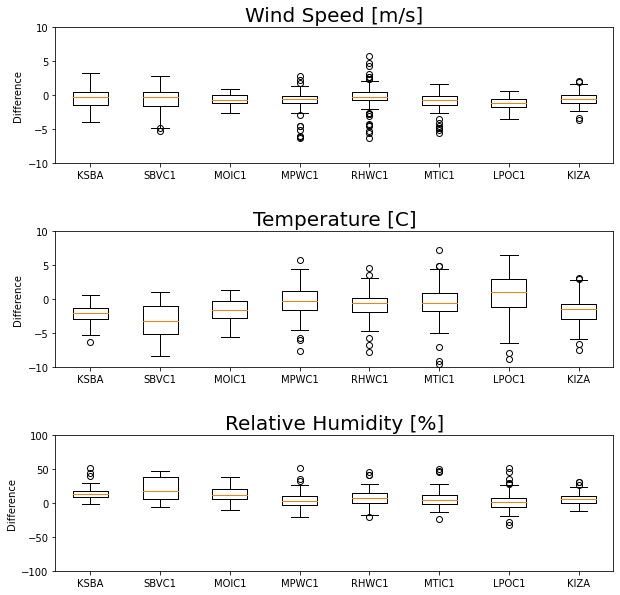

File saved as: /home/sbarc/students/coello/repos/classes/spring_2021/geog_288cj/plotting/outputs/figures/error_analysis_climo_KSBA_SBVC1_MOIC1_MPWC1_RHWC1_MTIC1_LPOC1_KIZA_wspd_t_RH_2017-05-21_17_to_2017-05-25_05.png 



In [34]:
station_errors(da, dclimo, da.time, stations,  station_vars, var_labels, var_lims, \
                 (10, 10), 'climo', fig_outdir)